dataset link : https://ai.stanford.edu/~amaas/data/sentiment/

About this file
Large Movie Review Dataset v1.0

#### Overview

This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.

Dataset

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). We also include an additional 50,000 unlabeled documents for unsupervised learning.

In the entire collection, no more than 30 reviews are allowed for any given movie because reviews for the same movie tend to have correlated ratings. Further, the train and test sets contain a disjoint set of movies, so no significant performance is obtained by memorizing movie-unique terms and their associated with observed labels. In the labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets. In the unsupervised set, reviews of any rating are included and there are an even number of reviews > 5 and <= 5.

In [1]:
import pandas as pd
import numpy as np

# Regular Expressions
import re

# os interface with other OS's, to read external file
import os
import warnings
warnings.filterwarnings('ignore')



### 1 . Import the files

In [5]:
# create strings with path names
parent_directory = 'C:\\Users\\Aviral Agarwal\\Desktop\\projects\\Sentiment Analysis\\Data\\aclImdb_v1\\aclImdb'
train_pos = parent_directory+'\\train\\pos'
train_neg = parent_directory+'\\train\\neg'
test_pos = parent_directory+'\\train\\pos'
test_neg = parent_directory+'\\train\\neg'

In [6]:
# read files into a list
positiveReviews, negativeReviews, testReviewsPositive, testReviewsNegative = [], [], [], []

for file in os.listdir(train_pos):
    f = open(train_pos+'\\'+file, encoding="latin1")
    positiveReviews.append(f.read())
    
for file in os.listdir(train_neg):
    f = open(train_neg+'\\'+file, encoding="latin1")
    negativeReviews.append(f.read())
    
for file in os.listdir(test_pos):
    f = open(test_pos+'\\'+file, encoding="latin1")
    testReviewsPositive.append(f.read())
    
for file in os.listdir(test_neg):
    f = open(test_neg+'\\'+file, encoding="latin1")
    testReviewsNegative.append(f.read())

In [7]:
print(len(positiveReviews))
print(len(negativeReviews))
print(len(testReviewsPositive))
print(len(testReviewsNegative))

12500
12500
12500
12500


In [9]:
positiveReviews[5]

"This isn't the comedic Robin Williams, nor is it the quirky/insane Robin Williams of recent thriller fame. This is a hybrid of the classic drama without over-dramatization, mixed with Robin's new love of the thriller. But this isn't a thriller, per se. This is more a mystery/suspense vehicle through which Williams attempts to locate a sick boy and his keeper.<br /><br />Also starring Sandra Oh and Rory Culkin, this Suspense Drama plays pretty much like a news report, until William's character gets close to achieving his goal.<br /><br />I must say that I was highly entertained, though this movie fails to teach, guide, inspect, or amuse. It felt more like I was watching a guy (Williams), as he was actually performing the actions, from a third person perspective. In other words, it felt real, and I was able to subscribe to the premise of the story.<br /><br />All in all, it's worth a watch, though it's definitely not Friday/Saturday night fare.<br /><br />It rates a 7.7/10 from...<br />

In [10]:
# converting train and test reviews to one dataframe each with label as 1 for positive and 0 for negative
reviews_train = pd.concat([
        pd.DataFrame({"Review":positiveReviews,"Label":1}),
        pd.DataFrame({"Review":negativeReviews,"Label":0})
        ],ignore_index=True)
len(reviews_train)

reviews_test = pd.concat([
        pd.DataFrame({"Review":testReviewsPositive,"Label":1}),
        pd.DataFrame({"Review":testReviewsNegative,"Label":0})
        ],ignore_index=True) 
len(reviews_test)

25000

In [11]:
reviews_train.tail()

,Review,Label
24995,"Towards the end of the movie, I felt it was to...",0
24996,This is the kind of movie that my enemies cont...,0
24997,I saw 'Descent' last night at the Stockholm Fi...,0
24998,Some films that you pick up for a pound turn o...,0
24999,"This is one of the dumbest films, I've ever se...",0


In [12]:
# checking for missing values although none expected
print(reviews_train.isnull().sum())
print(reviews_test.isnull().sum())

Review    0
Label     0
dtype: int64
Review    0
Label     0
dtype: int64


In [13]:
# SOME preparation for TRAIN data

#lets create Bag_of_Words(NaN for now) column
reviews_train['Bag_of_Words'] = np.nan

# when we concatenated positive and negative dataframes, all 1's and 0's were together, we have to shuffle them
df_train = reviews_train.sample(frac=1, axis=0)

# resetting the index
df_train = df_train.reset_index(drop=True)
df_train.head(10)

,Review,Label,Bag_of_Words
0,Maybe the greatest film ever about jazz.<br />...,1,NaN
1,The cast really helps make this a pleasant sur...,1,NaN
2,This has to be one of the 5 worst movies ever ...,0,NaN
3,How The Grinch Stole Christmas instantly stole...,1,NaN
4,DOes anyone know where or how i can get a copy...,1,NaN
5,"I loved this movie. First, because it is a fam...",1,NaN
6,This movie was awful and an insult to the view...,0,NaN
7,This movie is funny and painful at the same ti...,0,NaN
8,"Blood Castle (aka Scream of the Demon Lover, A...",1,NaN
9,"We all create our own reality, or do we? That ...",1,NaN


### 2 . Preprocessing

In [14]:
# libraries for preprocessing text data

# BeautifulSoup for cleaning web scrapping junk
from bs4 import BeautifulSoup

# python library for NLP
import nltk

# stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
# create list of stopwords
stopwords = set(stopwords.words("english"))

#nltk.download('wordnet')
import string

# stemming: find the root words for each word
# lemmatizer finds root words which are in the dictionary
from nltk.stem import WordNetLemmatizer
# create lemmatizer object
lemmatizer = WordNetLemmatizer()

from textblob import TextBlob
#python -m textblob.download_corpora
# https://www.clips.uantwerpen.be/pages/mbsp-tags


[nltk_data] Downloading package stopwords to C:\Users\Aviral
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# functions to perform preprocessing of data before training model
def remove_special_chars(review):
    '''Removes special characters except for ,.;? for negation ! extra weightage to these words'''
    
    # removing web scrapping junk
    review = BeautifulSoup(review)
    review = review.get_text()
    
    # check if removed by beautifulsoup, i think not required
    #review = re.sub(r'<br />', ' ', review)
    #review = re.sub(r'https?:\/\/.*[\r\n]*', '', review, flags=re.MULTILINE)
    
    # removing everything except for ,.;? for negation ! extra weightage to these words
    # also not removing ' as it is used in n't 
    review = re.sub(r'[_"\-%()|+&=*%:$@\[\]/]', ' ', review) 
    return review

#Creating new review of negated sentence
def check_for_negation(review):   
    '''Returns a list of sentences in the review with negation if any
    Scope for imporvement and refinement but that is manual coding'''
    new_review = []
    review_sentences = nltk.sent_tokenize(review)
    
    for line in review_sentences:
        if re.search("n't",line): #can be further refined using nor 
            to_negate_sent = line[line.find("n't")+4:line.find(",")] #can be further refined for . ; word-but as it negates the not
            negated_sent = ""
            complete_sent = ""
            for word in to_negate_sent.split():
                if word in stopwords:
                    negated_sent = negated_sent+word+" "
                else:
                    negated_sent = negated_sent+'NOT_'+word+" "   
            complete_sent = line[:line.find("n't")+4]+negated_sent+line[line.find(","):] # assuming only on , that too after negative word
            new_review.append(complete_sent)  
        else:
            new_review.append(line)
    return new_review

# using mark negation function
# problem in mark_negation, 
# 1. all words till the end of string is negated and not till , or . or ;
# 2. wordcloud was having NEG word
from nltk.sentiment.util import mark_negation
def check_for_negation_mark_negation(review):
    new_review = []
    
    # dividing into sentences
    # issue with nltk.sent_tokenize, sentences ending with goal.I are not handled
    review_sentences1 = nltk.sent_tokenize(review)
    # problem in mark_negation, all words till the end of string is negated
    # so we do the following
    review_sentences = re.split(r'[.,]', str(review_sentences1))
    
    for line in review_sentences:
        negated_sent= ""
        # would it not be handled above?
        line=re.sub('[.]',' ',line)#Not subsituting dot with '' since if word - goal.I it prints goalI instead of goal I
        negated_sent = mark_negation(line.split())
        new_review.append(negated_sent)  
    return new_review

def extract_ner_perform_spellcheck(new_review):
    ''' NER or Named Entity Recognizer
    Extracts NERs and NON NER words and performs spell check on NON NER words also does Lemmatization'''
    
    # Part of Speech Tagging using TextBlob
    blob = TextBlob(str(new_review))
    ner = []
    non_ner = ""
    puncs = set(string.punctuation)

    #Extracting Proper Nouns and making them in Upper case 
    for word, tag in blob.tags: 
        if tag in ['NNP','NNPS']: #proper noun, singular 'Harrison', proper noun, plural'Americans'
            ner.append(word.upper())
        else:
            non_ner = non_ner+word+" "
    # when I do str(new_review), it is taking the brackets of list also in the string
    non_ner = re.sub(r"[_'\-%()|+.&=*%:$@\[\]/]", " ", non_ner) #Remove special characters

    #Running spell check using TextBlob on Non-NER words
    non_ner_corrected = []
    non_ner_blob = TextBlob(str(non_ner)) #you need to pass a string of sentences to TextBlob and hence non_ner is a string not a list of words
    non_ner_blob = non_ner_blob.correct() #correct the words 
    non_ner_blob_cr = TextBlob(str(non_ner_blob)) #create a blob object for getting the tags

    # Extract only Adjectives, Adverbs, Nound and Verbs and also remove stopwords
    # this is as per requirement, here we are focussing on reviews and hence above type of words will have more influence
    # Lemmatisation is Faster than Stemmer, end result is a real word unlike stemmer
    for word, tag in non_ner_blob_cr.tags: #number not handled
            if word not in stopwords and (tag.startswith("JJ") or tag.startswith("NN") or tag.startswith("R") or tag.startswith("V")):
                if len(word)>2: # improvement: also check word.isalpha()                 
                    # by defautl lemmatize handles only noun
                    word = lemmatizer.lemmatize(word)
                    # for lemmatizing other than noun
                    if tag.startswith("V"):
                        word = lemmatizer.lemmatize(word,pos="v")
                    if tag.startswith("R"):
                        word = lemmatizer.lemmatize(word,pos="r")
                    if tag.startswith("J"):
                        word = lemmatizer.lemmatize(word,pos="a")
                    # non poper noun words are lower
                    word = word.lower()
                    non_ner_corrected.append(word)
    all_words = non_ner_corrected+ner
    all_words  = re.sub("[^a-zA-Z]"," ",str(all_words))
    return all_words

In [16]:
import datetime
print("Start of Cleaning Train Reviews ",datetime.datetime.now())

# iterating over rows of df_train
for index,row in df_train.iterrows():
    
    # for keeping check on process as it takes long time
    if index == 3000:
        break
    if index%200 == 0:
        print(index)
    
    # taking one review at a time
    review = df_train.loc[index,'Review']
    
    # remove_special_chars
    clean_review = remove_special_chars(review)
    
    # check_for_negation
    new_review = check_for_negation(clean_review)
    
    # extract_ner_perform_spellcheck and finally make bag_of_words and putting it in df_train['Bag_of_Words']
    bag_of_words = extract_ner_perform_spellcheck(new_review)
    df_train.loc[index,'Bag_Of_Words'] = bag_of_words

print("End of Cleaning Train Reviews ",datetime.datetime.now())

Start of Cleaning Train Reviews  2019-05-13 21:47:45.094666
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
End of Cleaning Train Reviews  2019-05-13 23:51:11.725202


In [17]:
# saving cleaned df_train as it takes long time to preprocess again
df_train.to_csv("df_train.csv",index=False)

In [18]:
df_train.head()

,Review,Label,Bag_of_Words,Bag_Of_Words
0,Maybe the greatest film ever about jazz.<br />...,1,NaN,maybe great film ever jazz ja...
1,The cast really helps make this a pleasant sur...,1,NaN,cast really help make pleasant ...
2,This has to be one of the 5 worst movies ever ...,0,NaN,bad move ever make plot look ...
3,How The Grinch Stole Christmas instantly stole...,1,NaN,instantly stole heart become fav...
4,DOes anyone know where or how i can get a copy...,1,NaN,anyone know get copy film sea...


## 3. Exploratory Data Analysis

In [19]:
#lets create Review_Length(length of reviews) for EDA
#reviews_train['Review_Length'] = reviews_train['Review'].str.len()
reviews_train['Review_Length'] = reviews_train['Review'].apply(len)

In [20]:
df = df_train.loc[0:2999,:]

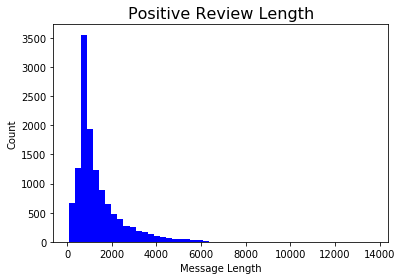

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting length of Review text for Positive Review
plt.hist(reviews_train[reviews_train['Label']==1]['Review_Length'],color='blue',bins=50)
plt.title('Positive Review Length',fontsize=16)
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

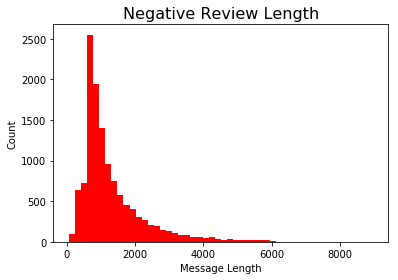

In [22]:
# Plotting length of Review text for Negative Review
plt.hist(reviews_train[reviews_train['Label']==0]['Review_Length'],color='red',bins=50)
plt.title('Negative Review Length',fontsize=16)
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

**Observation**: no relation between length of review and whether it is positive or negative.

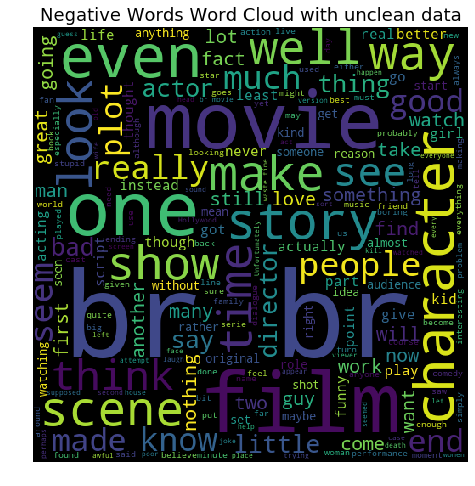

In [25]:
from wordcloud import WordCloud

negative_words = ' '.join(list(reviews_train[reviews_train['Label'] == 0]['Review']))
neg_wc = WordCloud(width=512,height=512).generate(negative_words)
plt.figure(figsize=(15,8))
plt.imshow(neg_wc)
plt.axis("off")
plt.title("Negative Words Word Cloud with unclean data",fontsize=18)
plt.show()

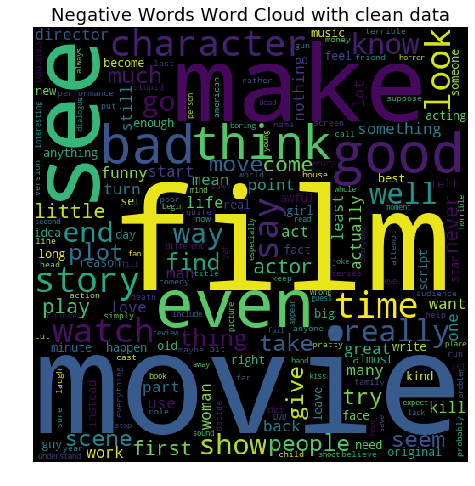

In [26]:
negative_words = ' '.join(list(df[df['Label'] == 0]['Bag_Of_Words']))
neg_wc = WordCloud(width=512,height=512).generate(negative_words)
plt.figure(figsize=(15,8))
plt.imshow(neg_wc)
plt.axis("off")
plt.title("Negative Words Word Cloud with clean data",fontsize=18)
plt.show()

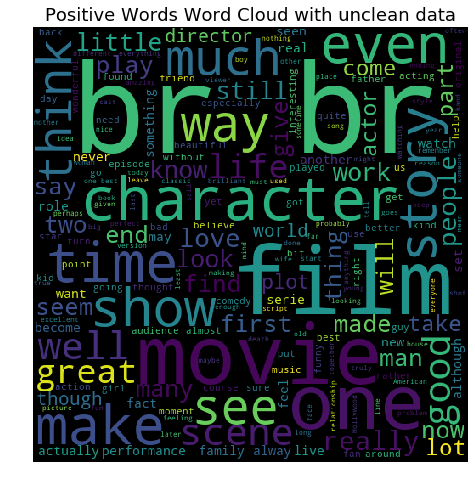

In [27]:
positive_words = ' '.join(list(reviews_train[reviews_train['Label'] == 1]['Review']))
pos_wc = WordCloud(width=512,height=512).generate(positive_words)
plt.figure(figsize=(15,8))
plt.imshow(pos_wc)
plt.axis("off")
plt.title("Positive Words Word Cloud with unclean data",fontsize=18)
plt.show()

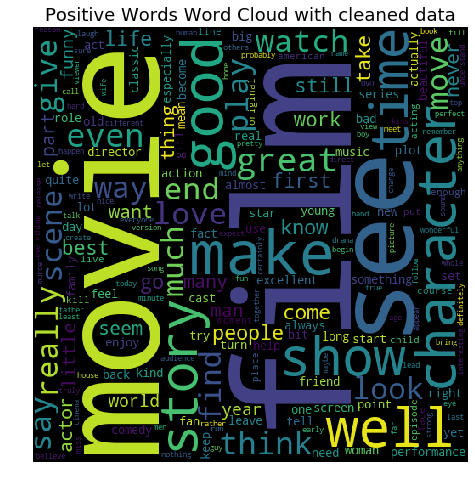

In [28]:
positive_words = ' '.join(list(df[df['Label'] == 1]['Bag_Of_Words']))
pos_wc = WordCloud(width=512,height=512).generate(positive_words)
plt.figure(figsize=(15,8))
plt.imshow(pos_wc)
plt.axis("off")
plt.title("Positive Words Word Cloud with cleaned data",fontsize=18)
plt.show()

## 4. Model Building  

**NaiveBayes**: uses Naive Bayes Theorem  
Assumes that all independent features are independent of each other, an assumtion which fails in reality but works well practically  
GaussianNB assumes that independent features were extracted from same Gaussian/Normal Distribution  
MultiNomialNB assumes that independent features were extracted from different or multiple normal distributions.  


**Empirically seen, For NLP, MultinomiaNB with CountVectorizer works very well**

**ngram_range**: means if we want to consider only given Bag_Of_Words or we want to make combinations of words too.  
if ngram_range = (1,2) we are making combination of two words and considering them in the matrix too.  

### 4.1 TF-IDF   
tf means term frequency i.e. frequency of the tern in current document. here one review  
idf means inverse document frequency = log(n/docFreq)+1 where docFreq= document frequency=no. of docs where the term appears/total no. of documents  

we do smoothing to handle a case where we see a new word in test data and docFreq=0 because no. of docs where term appears=0  
with smoothning, we assume that we have one more document which has entire terms so idf=log((n+1)/(docFreq+1))+1  

####  TF-IDF unigram model

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding='latin-1',analyzer='word',lowercase=False,smooth_idf=True)

In [30]:
#Splitting into train and test dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df['Bag_Of_Words'], df["Label"], test_size = 0.30, random_state = 0)

In [31]:
features_train = tfidf.fit_transform(X_train)
features_test = tfidf.transform(X_test)
print(type(features_train))
pd.DataFrame(features_train.todense(),columns=tfidf.get_feature_names())

<class 'scipy.sparse.csr.csr_matrix'>


,AA,AAA,AAG,AAMES,AAMIR,AANKHEN,AARON,AAVJO,AB,ABBEY,...,zen,zenith,zero,zest,zigzag,zip,zombiefied,zone,zoolander,zum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [32]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(features_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [33]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
prediction = model.predict(features_test)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

0.8277777777777777
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       434
           1       0.80      0.89      0.84       466

   micro avg       0.83      0.83      0.83       900
   macro avg       0.83      0.83      0.83       900
weighted avg       0.83      0.83      0.83       900



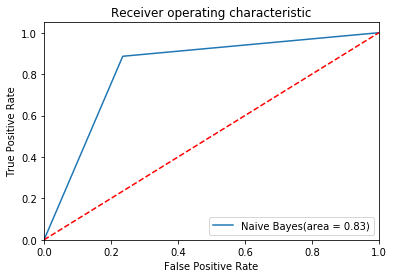

In [34]:
from sklearn import metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

nb_roc_auc = roc_auc_score(y_test,prediction)
fpr, tpr, thresholds = roc_curve(y_test,prediction)
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes(area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### TF-IDF bigram model

In [35]:
tfidf = TfidfVectorizer(encoding='latin-1',analyzer='word',lowercase=False,smooth_idf=True,ngram_range=(1,2))

X_train, X_test, y_train, y_test = train_test_split(df['Bag_Of_Words'], df["Label"], test_size = 0.30, random_state = 0)
features_train = tfidf.fit_transform(X_train)
features_test = tfidf.transform(X_test)

model = MultinomialNB()
model.fit(features_train,y_train)

prediction = model.predict(features_test)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))
print("ROC Score",roc_auc_score(y_test,prediction))

0.8122222222222222
              precision    recall  f1-score   support

           0       0.91      0.68      0.78       434
           1       0.76      0.94      0.84       466

   micro avg       0.81      0.81      0.81       900
   macro avg       0.83      0.81      0.81       900
weighted avg       0.83      0.81      0.81       900

ROC Score 0.807672909950357


### 4.2 Count Vectorizer

#### 1. Using Uni gram and Gaussian NB

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df['Bag_Of_Words'], df["Label"], test_size = 0.30, random_state = 0)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(lowercase=False,max_features=10000)
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

In [38]:
X_test.shape

(900, 10000)

In [39]:
X_train.shape

(2100, 10000)

In [40]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train,y_train)

# Predicting Test Results
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.6544444444444445
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       434
           1       0.69      0.61      0.65       466

   micro avg       0.65      0.65      0.65       900
   macro avg       0.66      0.66      0.65       900
weighted avg       0.66      0.65      0.65       900



In [41]:
roc_auc_score(y_test,y_pred)

0.6560244061628528

#### 2. Using Uni gram and MultiNomial NB

In [42]:
model = MultinomialNB()
model.fit(X_train,y_train)

prediction = model.predict(X_test)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))
print("ROC Score" ,roc_auc_score(y_test,prediction))

0.8144444444444444
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       434
           1       0.85      0.78      0.81       466

   micro avg       0.81      0.81      0.81       900
   macro avg       0.82      0.82      0.81       900
weighted avg       0.82      0.81      0.81       900

ROC Score 0.8157522596467633


#### 3. Using Bi gram and Gaussian NB

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df['Bag_Of_Words'], df["Label"], test_size = 0.30, random_state = 0)

cv = CountVectorizer(lowercase=False,max_features=10000,ngram_range=(1, 2))
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()


In [44]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train,y_train)

# Predicting Test Results
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("ROC Score" ,roc_auc_score(y_test,y_pred))

0.6666666666666666
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       434
           1       0.71      0.59      0.65       466

   micro avg       0.67      0.67      0.67       900
   macro avg       0.67      0.67      0.67       900
weighted avg       0.67      0.67      0.67       900

ROC Score 0.6693301160973872


#### 4. Using Bi gram and Multinomial NB

In [45]:
model = MultinomialNB()
model.fit(X_train,y_train)

prediction = model.predict(X_test)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))
print("ROC Score" ,roc_auc_score(y_test,prediction))

0.8222222222222222
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       434
           1       0.84      0.80      0.82       466

   micro avg       0.82      0.82      0.82       900
   macro avg       0.82      0.82      0.82       900
weighted avg       0.82      0.82      0.82       900

ROC Score 0.8228674274638555


#### 5. Using Tri gram and Multinomial NB

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df['Bag_Of_Words'], df["Label"], test_size = 0.30, random_state = 0)

cv = CountVectorizer(lowercase=False,max_features=10000,ngram_range=(1, 3))
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

model = MultinomialNB()
model.fit(X_train,y_train)

prediction = model.predict(X_test)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))
print("ROC Score" ,roc_auc_score(y_test,prediction))

0.8177777777777778
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       434
           1       0.84      0.80      0.82       466

   micro avg       0.82      0.82      0.82       900
   macro avg       0.82      0.82      0.82       900
weighted avg       0.82      0.82      0.82       900

ROC Score 0.8183382448923083


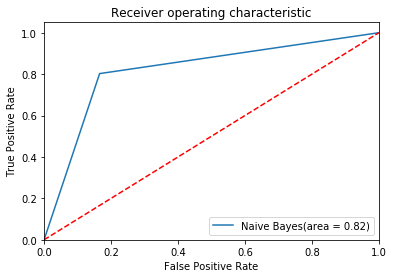

In [47]:
nb_roc_auc = roc_auc_score(y_test,prediction)
fpr, tpr, thresholds = roc_curve(y_test,prediction)
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes(area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**Inference**: best performance from MultinomialNB with ngram_range=(1,2)